In [3]:
import numpy as np
import pywt
import os
from PIL import Image
from scipy.fftpack import dct
from scipy.fftpack import idct
from math import log10, sqrt

#current_path = str(os.path.dirname(__file__))  

image = 'images/chihuahua.webp'   
watermark = 'images/watermark.jpg' 

def convert_image(image_name, size):
    img = Image.open(image_name).resize((size, size), 1)
    img = img.convert('L')
    img.save(image_name)

    # image_array = np.array(img)
    # image_array = np.float32(image_array) 
    # image_array /= 255 
    image_array = np.array(img.getdata(), dtype=np.float64).reshape((size, size))
    #print(image_array[0][0])               #qrcode white color = 1.0
    #print(image_array[10][10])             #qrcode black color = 0.0  

    return image_array

def process_coefficients(imArray, model, level):
    #pywt - wavelet transforms in Python: Multilevel 2D Discrete Wavelet Transform.
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    print('Coeffs: ', coeffs[0].__len__())    
    
    coeffs_H=list(coeffs)
    
    return coeffs_H
            
    
def embed_watermark(watermark_array, orig_image):
    watermark_array_size = watermark_array[0].__len__()
    
    #ravel(): return a contiguous flattened 1D array
    watermark_flat = watermark_array.ravel()
    
    ind = 0

    for x in range (0, orig_image.__len__(), 8):
        for y in range (0, orig_image.__len__(), 8):
            if ind < watermark_flat.__len__():
                subdct = orig_image[x:x+8, y:y+8]
                subdct[5][5] = watermark_flat[ind]
                orig_image[x:x+8, y:y+8] = subdct
                ind += 1 
    return orig_image
      


def apply_dct(image_array):
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct


def inverse_dct(all_subdct):
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct


def get_watermark(dct_watermarked_coeff, watermark_size):
    # watermark = [[0 for x in range(watermark_size)] for y in range(watermark_size)] 

    subwatermarks = []

    for x in range (0, dct_watermarked_coeff.__len__(), 8):
        for y in range (0, dct_watermarked_coeff.__len__(), 8):
            coeff_slice = dct_watermarked_coeff[x:x+8, y:y+8]
            subwatermarks.append(coeff_slice[5][5])

    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)

    return watermark


def recover_watermark(image_array, model='haar', level = 1):
    coeffs_watermarked_image = process_coefficients(image_array, model, level=level)
   
    dct_watermarked_coeff = apply_dct(coeffs_watermarked_image[0])
    
    watermark_array = get_watermark(dct_watermarked_coeff, 128)

    # watermark_array *= 255;
    watermark_array =  np.uint8(watermark_array)

    #Save result
    img = Image.fromarray(watermark_array)
    img.save('./result/recovered_watermark.jpg')


def print_image_from_array(image_array, name):
    # image_array *= 255;
    # image_array =  np.uint8(image_array)
    image_array_copy = image_array.clip(0, 255)
    image_array_copy = image_array_copy.astype("uint8")
    img = Image.fromarray(image_array_copy)
    img.save('./result/' + name)
    
def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def w2d(img):
    model = 'haar'
    level = 1
    image_array = convert_image(image, 2048)
    watermark_array = convert_image(watermark, 128)

    coeffs_image = process_coefficients(image_array, model, level=level)
    #print('Length of coeffes',len(coeffs_image))
    
    print_image_from_array(coeffs_image[0], 'LL_after_DWT.jpg')

    dct_array = apply_dct(coeffs_image[0])
    print_image_from_array(dct_array, 'LL_after_DCT.jpg')

    dct_array = embed_watermark(watermark_array, dct_array)
    print_image_from_array(dct_array, 'LL_after_embeding.jpg')

    coeffs_image[0] = inverse_dct(dct_array)
    print_image_from_array(coeffs_image[0], 'LL_after_IDCT.jpg')


    # reconstruction
    #waverec2 = Multilevel 2D Inverse Discrete Wavelet Transform.
    image_array_H=pywt.waverec2(coeffs_image, model)
    print_image_from_array(image_array_H, 'image_with_watermark.jpg')

    # recover images
    recover_watermark(image_array = image_array_H, model=model, level = level)
    
    #Calculate psnr
    #original = Image.open('mis1.jpg')
    original = image_array
    watermarked = image_array_H
    value = PSNR(original, watermarked)
    print('PSNR value is',value, 'dB')

In [5]:
w2d("test")

Coeffs:  1024
Coeffs:  1024
PSNR value is 26.18510877211094 dB


### gpt

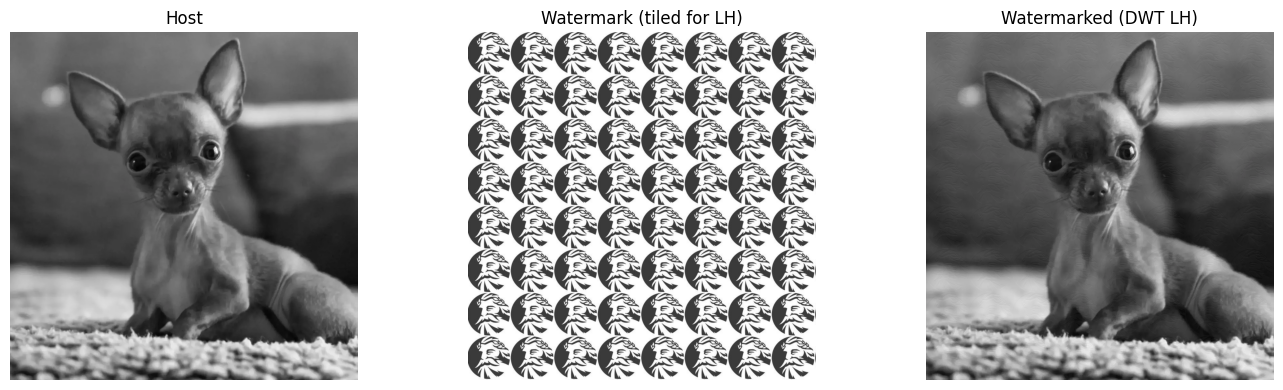

In [9]:
# DWT color watermark embedding with TILING (no resizing; no saving)
# - Host and watermark can be different sizes.
# - Watermark is tiled to exactly cover the chosen DWT subband.
# - Color-to-color embedding (R->R subband, G->G, B->B).
# - Displays output using matplotlib only (no files written).

import numpy as np
from PIL import Image
import pywt
import matplotlib.pyplot as plt

# ================== CONFIG ==================
HOST_PATH = "images/chihuahua.webp"
WATERMARK_PATH = "images/watermark.jpg"
WAVELET = "haar"
SUBBAND = "LH"         # {"LL","LH","HL","HH"}
ALPHA = 0.4          # embedding strength
RANDOM_OFFSET = True   # randomize tiling phase to avoid obvious seams
SEED = 1234            # seed for reproducibility when RANDOM_OFFSET=True

# ================== UTILS ==================
def to_float01(arr):
    arr = np.asarray(arr)
    if arr.dtype != np.float32 and arr.dtype != np.float64:
        arr = arr.astype(np.float32) / 255.0
    return np.clip(arr, 0.0, 1.0)

def load_or_make_host():
    if HOST_PATH:
        return to_float01(np.array(Image.open(HOST_PATH).convert("RGB")))
    H, W = 256, 256
    y = np.linspace(0, 1, H, dtype=np.float32)[:, None]
    x = np.linspace(0, 1, W, dtype=np.float32)[None, :]
    R = np.tile(x, (H, 1))
    G = np.tile(y, (1, W))
    B = 0.5*(1 - np.tile(x, (H, 1))) + 0.5*(1 - np.tile(y, (1, W)))
    return np.stack([R, G, B], axis=-1)

def load_or_make_wm():
    if WATERMARK_PATH:
        return to_float01(np.array(Image.open(WATERMARK_PATH).convert("RGB")))
    # small colorful pattern (e.g., 96x120)
    H, W = 96, 120
    xx, yy = np.meshgrid(np.linspace(0, 1, W, dtype=np.float32),
                         np.linspace(0, 1, H, dtype=np.float32))
    wm = np.stack([
        0.5 + 0.5*np.sin(8*np.pi*xx),
        0.5 + 0.5*np.sin(8*np.pi*yy),
        ((xx>0.35)&(xx<0.65)&(yy>0.35)&(yy<0.65)).astype(np.float32)
    ], axis=-1)
    return wm

def dwt2(ch, wavelet="haar"):
    LL, (LH, HL, HH) = pywt.dwt2(ch, wavelet=wavelet)
    return {"LL":LL, "LH":LH, "HL":HL, "HH":HH}

def idwt2(subbands, wavelet="haar"):
    return pywt.idwt2((subbands["LL"], (subbands["LH"], subbands["HL"], subbands["HH"])), wavelet=wavelet)

def tile_to_shape(arr, target_hw, random_offset=False, rng=None):
    """
    Tile 2D or 3D array (H,W[,C]) to exactly match target_hw=(TH,TW).
    No interpolation; just repetition. Optionally randomize tile phase.
    """
    H, W = arr.shape[:2]
    TH, TW = target_hw
    if arr.ndim == 2:
        C = None
    else:
        C = arr.shape[2]

    # optional random phase to break seams
    if random_offset:
        if rng is None:
            rng = np.random.default_rng()
        off_y = rng.integers(0, H)
        off_x = rng.integers(0, W)
        if C is None:
            arr = np.roll(np.roll(arr, off_y, axis=0), off_x, axis=1)
        else:
            arr = np.roll(np.roll(arr, off_y, axis=0), off_x, axis=1)

    # compute repeats
    ry = (TH + H - 1) // H
    rx = (TW + W - 1) // W
    if C is None:
        tiled = np.tile(arr, (ry, rx))[:TH, :TW]
    else:
        tiled = np.tile(arr, (ry, rx, 1))[:TH, :TW, :]
    return tiled

# ================== EMBEDDING (TILING) ==================
def embed_dwt_rgb_tiled(host_rgb, wm_rgb, wavelet="haar", subband="LH", alpha=0.035, random_offset=True, seed=None):
    """
    Tiled color watermark embedding in a chosen DWT subband (per RGB channel).
    - host_rgb: HxWx3 float [0,1]
    - wm_rgb:   h_wmxw_wm x 3 float [0,1] (any size)
    - No resizing; watermark is tiled to cover subband size.
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    R, G, B = host_rgb[...,0], host_rgb[...,1], host_rgb[...,2]

    R_sb = dwt2(R, wavelet); G_sb = dwt2(G, wavelet); B_sb = dwt2(B, wavelet)
    # Get target subband spatial size from, say, Red channel
    TH, TW = R_sb[subband].shape

    # Prepare color watermark tiled to subband size
    # If wm is grayscale (H,W), broadcast to 3 channels
    if wm_rgb.ndim == 2:
        wm_rgb = np.stack([wm_rgb, wm_rgb, wm_rgb], axis=-1)

    wm_tiled = tile_to_shape(wm_rgb, (TH, TW), random_offset=random_offset, rng=rng)

    # Center watermark values to zero-mean for additive embedding
    wR = wm_tiled[...,0] - 0.5
    wG = wm_tiled[...,1] - 0.5
    wB = wm_tiled[...,2] - 0.5

    # Add to chosen subband per channel
    R_sb[subband] = R_sb[subband] + alpha * wR
    G_sb[subband] = G_sb[subband] + alpha * wG
    B_sb[subband] = B_sb[subband] + alpha * wB

    # Inverse DWT per channel
    Rw = np.clip(idwt2(R_sb, wavelet), 0.0, 1.0)
    Gw = np.clip(idwt2(G_sb, wavelet), 0.0, 1.0)
    Bw = np.clip(idwt2(B_sb, wavelet), 0.0, 1.0)
    out = np.stack([Rw, Gw, Bw], axis=-1)

    return out, wm_tiled

# ================== DEMO (DISPLAY ONLY) ==================
host = load_or_make_host()
wm = load_or_make_wm()

watermarked, wm_tiled = embed_dwt_rgb_tiled(
    host, wm,
    wavelet=WAVELET,
    subband=SUBBAND,
    alpha=ALPHA,
    random_offset=RANDOM_OFFSET,
    seed=SEED
)

# Show (no writing to disk)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].imshow(host); ax[0].set_title("Host"); ax[0].axis('off')
ax[1].imshow(wm_tiled); ax[1].set_title(f"Watermark (tiled for {SUBBAND})"); ax[1].axis('off')
ax[2].imshow(watermarked); ax[2].set_title(f"Watermarked (DWT {SUBBAND})"); ax[2].axis('off')
plt.tight_layout(); 
plt.show()


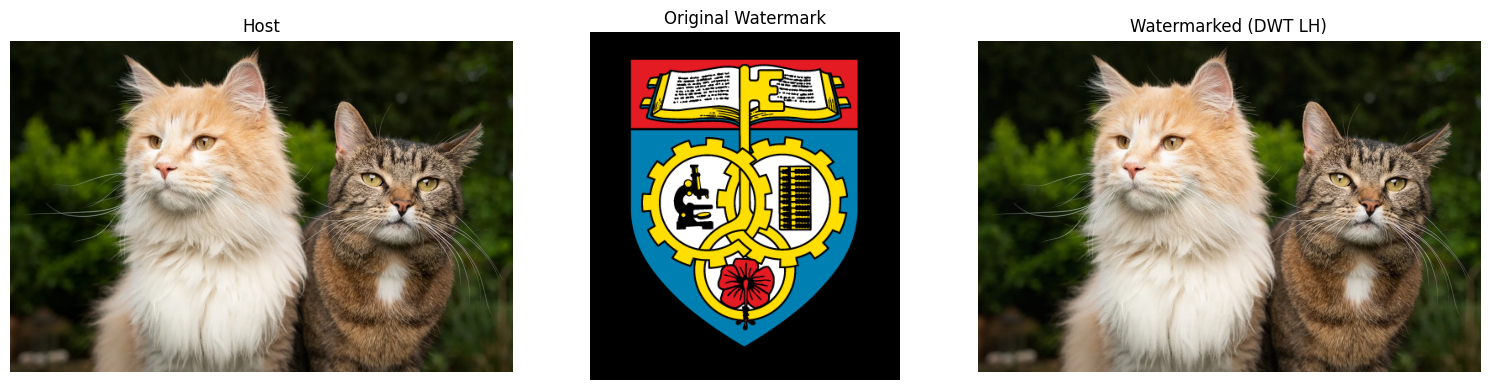

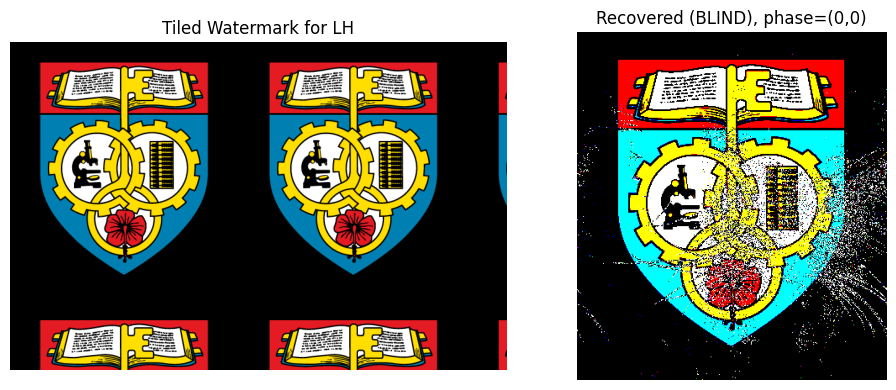

In [26]:
# DWT color watermarking — Spread-Spectrum (BLIND extraction)
# - Host & watermark can be different sizes (tiling used; NO resizing).
# - Embedding: subband += alpha * PN * sign(tiled_watermark - 0.5)
# - Extraction (blind): correlate subband with PN, fold modulo watermark size → recover.
# - Color-to-color: independent PN per RGB channel, single chosen subband.
# - No files written; figures only.
#
# Requirements: pip install pillow pywavelets matplotlib

import numpy as np
from PIL import Image
import pywt
import matplotlib.pyplot as plt

# ================== CONFIG ==================
HOST_PATH = "images/cat.webp"
WATERMARK_PATH = "images/logo.png"
WAVELET   = "haar"
SUBBAND   = "LH"         # {"LL","LH","HL","HH"} (mid-bands recommended)
ALPHA     = 0.05         # embedding strength
RANDOM_OFFSET = True
KEY       = 20250811     # secret key for PN sequences (must be known at extraction)

# ================== UTILS ==================
def to_float01(a):
    a = np.asarray(a)
    if a.dtype not in (np.float32, np.float64):
        a = a.astype(np.float32)/255.0
    return np.clip(a, 0.0, 1.0)

def load_or_make_host():
    if HOST_PATH:
        return to_float01(np.array(Image.open(HOST_PATH).convert("RGB")))
    H, W = 256, 256
    y = np.linspace(0, 1, H, dtype=np.float32)[:, None]
    x = np.linspace(0, 1, W, dtype=np.float32)[None, :]
    R = np.tile(x, (H, 1))
    G = np.tile(y, (1, W))
    B = 0.5*(1 - np.tile(x, (H, 1))) + 0.5*(1 - np.tile(y, (1, W)))
    return np.stack([R, G, B], axis=-1)

def load_or_make_wm():
    if WATERMARK_PATH:
        return to_float01(np.array(Image.open(WATERMARK_PATH).convert("RGB")))
    H, W = 90, 130
    xx, yy = np.meshgrid(np.linspace(0,1,W,dtype=np.float32),
                         np.linspace(0,1,H,dtype=np.float32))
    wm = np.stack([
        0.5 + 0.5*np.sin(8*np.pi*xx),
        0.5 + 0.5*np.sin(8*np.pi*yy),
        ((xx>0.34)&(xx<0.66)&(yy>0.34)&(yy<0.66)).astype(np.float32)
    ], axis=-1)
    return wm

def dwt2(ch, wavelet="haar"):
    LL, (LH, HL, HH) = pywt.dwt2(ch, wavelet=wavelet)
    return {"LL":LL, "LH":LH, "HL":HL, "HH":HH}

def idwt2(sb, wavelet="haar"):
    return pywt.idwt2((sb["LL"], (sb["LH"], sb["HL"], sb["HH"])), wavelet=wavelet)

def tile_to_shape(arr, target_hw, random_offset=False, rng=None):
    H, W = arr.shape[:2]
    TH, TW = target_hw
    if random_offset:
        offy = rng.integers(0, H)
        offx = rng.integers(0, W)
        arr = np.roll(np.roll(arr, offy, axis=0), offx, axis=1)
    ry = (TH + H - 1) // H
    rx = (TW + W - 1) // W
    if arr.ndim == 2:
        return np.tile(arr, (ry, rx))[:TH, :TW]
    return np.tile(arr, (ry, rx, 1))[:TH, :TW, :]

def pn_sequence(shape, seed):
    """±1 PN with zero mean."""
    rng = np.random.default_rng(seed)
    return rng.choice([-1.0, 1.0], size=shape).astype(np.float32)

def fold_untile(arr, h, w, oy=0, ox=0):
    """Average pixels whose indices are congruent modulo (h,w) after offset (oy,ox)."""
    H, W = arr.shape[:2]
    C = 1 if arr.ndim == 2 else arr.shape[2]
    out = np.zeros((h, w, C), dtype=np.float64)
    cnt = np.zeros((h, w, 1), dtype=np.int32)
    for y in range(H):
        yy = (y - oy) % h
        for x in range(W):
            xx = (x - ox) % w
            if C == 1:
                out[yy, xx, 0] += arr[y, x]
            else:
                out[yy, xx, :] += arr[y, x, :]
            cnt[yy, xx, 0] += 1
    out /= np.maximum(cnt, 1)
    if C == 1: out = out[...,0]
    return out

def estimate_offset_from_corr(corr_rgb, h, w):
    """Find tiling phase by maximizing variance of the folded correlation."""
    best, best_oy, best_ox = -1, 0, 0
    step_y = 1 if h <= 160 else max(1, h//80)
    step_x = 1 if w <= 160 else max(1, w//80)
    for oy in range(0, h, step_y):
        for ox in range(0, w, step_x):
            tmp = fold_untile(corr_rgb, h, w, oy, ox)
            v = tmp.var()
            if v > best:
                best, best_oy, best_ox = v, oy, ox
    return best_oy, best_ox

# ================== EMBED (SPREAD-SPECTRUM, BLIND) ==================
def embed_spread_spectrum_rgb(host_rgb, wm_rgb, wavelet="haar", subband="LH",
                              alpha=0.05, random_offset=True, key=1234):
    """
    subband += alpha * PN * sign(tile(wm) - 0.5), per RGB channel.
    Returns: watermarked_rgb, wm_tiled_rgb, offsets (oy,ox)
    """
    rng = np.random.default_rng(key)
    if wm_rgb.ndim == 2:
        wm_rgb = np.stack([wm_rgb, wm_rgb, wm_rgb], axis=-1)

    R, G, B = host_rgb[...,0], host_rgb[...,1], host_rgb[...,2]
    Rb, Gb, Bb = dwt2(R, wavelet), dwt2(G, wavelet), dwt2(B, wavelet)
    TH, TW = Rb[subband].shape

    # tile watermark to subband shape
    # oy = rng.integers(0, wm_rgb.shape[0]) if random_offset else 0
    # ox = rng.integers(0, wm_rgb.shape[1]) if random_offset else 0
    # wm_roll = np.roll(np.roll(wm_rgb, oy, 0), ox, 1)
    # wm_tiled = tile_to_shape(wm_roll, (TH, TW), random_offset=False, rng=rng)
    oy = 0
    ox = 0
    wm_roll  = wm_rgb  # no np.roll
    wm_tiled = tile_to_shape(wm_roll, (TH, TW))  # exact top-left start

    S = np.sign(wm_tiled - 0.5).astype(np.float32)  # in {-1, +1}

    # PN per channel (same shape as subband)
    # PN_R = pn_sequence((TH, TW), seed=key + 11)
    # PN_G = pn_sequence((TH, TW), seed=key + 29)
    # PN_B = pn_sequence((TH, TW), seed=key + 47)
    PN_R = pn_sequence((TH, TW), seed=key)
    PN_G = pn_sequence((TH, TW), seed=key)
    PN_B = pn_sequence((TH, TW), seed=key)

    # embed
    Ra = {k:v.copy() for k,v in Rb.items()}
    Ga = {k:v.copy() for k,v in Gb.items()}
    Ba = {k:v.copy() for k,v in Bb.items()}
    Ra[subband] += alpha * PN_R * S[...,0]
    Ga[subband] += alpha * PN_G * S[...,1]
    Ba[subband] += alpha * PN_B * S[...,2]

    # iDWT
    Rw = np.clip(idwt2(Ra, wavelet), 0.0, 1.0)
    Gw = np.clip(idwt2(Ga, wavelet), 0.0, 1.0)
    Bw = np.clip(idwt2(Ba, wavelet), 0.0, 1.0)
    wmi = np.stack([Rw, Gw, Bw], axis=-1)
    return wmi, wm_tiled, (oy, ox)

# ================== EXTRACT (BLIND) ==================
def extract_spread_spectrum_rgb(wmi_rgb, wm_size, wavelet="haar", subband="LH",
                                alpha=0.05, key=1234, search_offset=True):
    """
    Blind extraction:
      corr_c = subband_c * PN_c  (element-wise)
      fold corr back to (wm_h, wm_w) by modulo-averaging (phase search optional)
      sign(corr) -> {-1,+1} -> map to [0,1]
    """
    wm_h, wm_w = wm_size

    R, G, B = wmi_rgb[...,0], wmi_rgb[...,1], wmi_rgb[...,2]
    Rb, Gb, Bb = dwt2(R, wavelet), dwt2(G, wavelet), dwt2(B, wavelet)

    TH, TW = Rb[subband].shape
    # PN_R = pn_sequence((TH, TW), seed=key + 11)
    # PN_G = pn_sequence((TH, TW), seed=key + 29)
    # PN_B = pn_sequence((TH, TW), seed=key + 47)
    PN_R = pn_sequence((TH, TW), seed=key)
    PN_G = pn_sequence((TH, TW), seed=key)
    PN_B = pn_sequence((TH, TW), seed=key)

    # element-wise correlation with PN (acts like matched filter)
    cR = Rb[subband] * PN_R
    cG = Gb[subband] * PN_G
    cB = Bb[subband] * PN_B
    corr_rgb = np.stack([cR, cG, cB], axis=-1)

    # estimate tiling offset if not known
    if search_offset:
        oy, ox = estimate_offset_from_corr(corr_rgb, wm_h, wm_w)
    else:
        oy, ox = 0, 0

    folded = fold_untile(corr_rgb, wm_h, wm_w, oy, ox)  # shape (h,w,3)
    # Normalize by mean absolute for stability, then threshold sign
    eps = 1e-8
    norm = np.mean(np.abs(folded), axis=(0,1), keepdims=True) + eps
    sgn = np.sign(folded / norm)
    wm_est = (sgn + 1.0) * 0.5  # map {-1,+1} -> {0,1}
    wm_est = np.clip(wm_est, 0.0, 1.0)
    return wm_est, (oy, ox)

# ================== DEMO ==================
host = load_or_make_host()
wm   = load_or_make_wm()

# EMBED (uses KEY; random tiling phase hidden in the stream)
wmi, wm_tiled, offsets = embed_spread_spectrum_rgb(
    host, wm, wavelet=WAVELET, subband=SUBBAND, alpha=ALPHA,
    random_offset=RANDOM_OFFSET, key=KEY
)

# BLIND EXTRACT (uses only KEY and wm.shape)
wm_rec, (oy, ox) = extract_spread_spectrum_rgb(
    wmi, wm.shape[:2], wavelet=WAVELET, subband=SUBBAND, alpha=ALPHA,
    key=KEY, search_offset=False
)

# ---- Display (no saving) ----
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(host); ax[0].set_title("Host"); ax[0].axis('off')
ax[1].imshow(wm);   ax[1].set_title("Original Watermark"); ax[1].axis('off')
ax[2].imshow(wmi);  ax[2].set_title(f"Watermarked (DWT {SUBBAND})"); ax[2].axis('off')
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(wm_tiled); ax[0].set_title(f"Tiled Watermark for {SUBBAND}"); ax[0].axis('off')
ax[1].imshow(wm_rec);   ax[1].set_title(f"Recovered (BLIND), phase=({oy},{ox})"); ax[1].axis('off')
plt.tight_layout(); plt.show()

[Embed] PSNR ≈ 32.78 dB | watermarked saved to: images/host_watermarked.png
[Embed] Side-info saved to: images/watermark_sideinfo.json


C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_34076\4152797671.py:106: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode='L')


[Extract] Bit accuracy vs original watermark: 100.00%
[Extract] Recovered watermark saved to: images/recovered_watermark.png


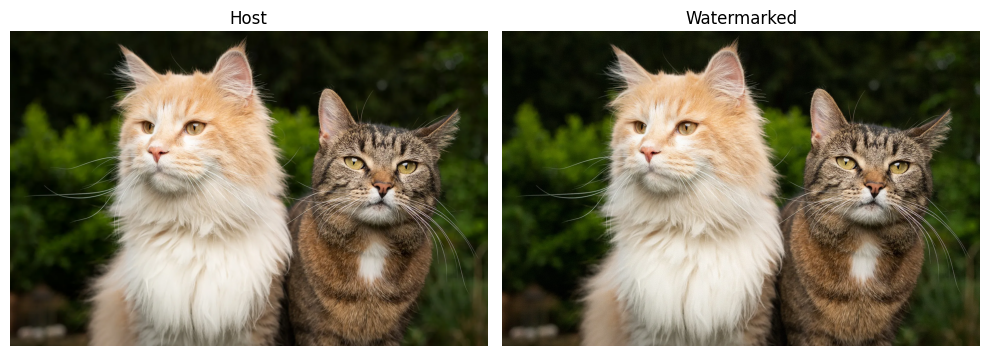

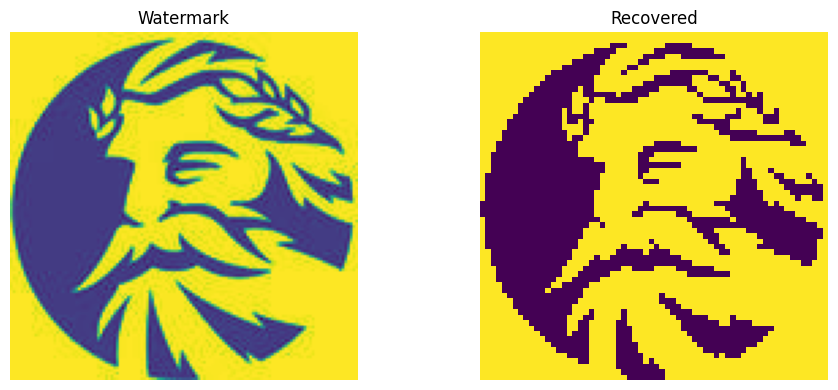

In [6]:
import numpy as np
from PIL import Image, ImageOps
import json
import os
import matplotlib.pyplot as plt

# --------------------------
# Utility: PSNR
# --------------------------
def psnr(img_a, img_b, max_val=255.0):
    a = img_a.astype(np.float64)
    b = img_b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return 99.0
    return 20 * np.log10(max_val / np.sqrt(mse))

# --------------------------
# Color space conversion (RGB <-> YCbCr) in float
# --------------------------
def rgb_to_ycbcr(rgb):
    # rgb: HxWx3 in [0,255]
    rgb = rgb.astype(np.float64)
    R, G, B = rgb[...,0], rgb[...,1], rgb[...,2]
    # ITU-R BT.601 conversion
    Y  =  0.299*R + 0.587*G + 0.114*B
    Cb = -0.168736*R - 0.331264*G + 0.5*B + 128
    Cr =  0.5*R - 0.418688*G - 0.081312*B + 128
    return np.stack([Y, Cb, Cr], axis=-1)

def ycbcr_to_rgb(ycbcr):
    Y, Cb, Cr = ycbcr[...,0], ycbcr[...,1], ycbcr[...,2]
    Cb = Cb - 128
    Cr = Cr - 128
    R = Y + 1.402 * Cr
    G = Y - 0.344136 * Cb - 0.714136 * Cr
    B = Y + 1.772 * Cb
    rgb = np.stack([R,G,B], axis=-1)
    return np.clip(rgb, 0, 255).astype(np.uint8)

# --------------------------
# 1-level 2D Haar DWT and inverse (single-channel)
# --------------------------
def haar_dwt2(img):
    """
    1-level 2D Haar DWT on a single-channel float image.
    Returns LL, LH, HL, HH (all shape H/2 x W/2).
    """
    img = img.astype(np.float64)
    H, W = img.shape
    if (H % 2) or (W % 2):
        raise ValueError("Image height and width must be even for 1-level DWT.")
    # Row-wise split
    low_rows  = (img[:, 0::2] + img[:, 1::2]) / 2.0
    high_rows = (img[:, 0::2] - img[:, 1::2]) / 2.0
    # Col-wise on low/high
    LL = (low_rows[0::2, :] + low_rows[1::2, :]) / 2.0
    LH = (low_rows[0::2, :] - low_rows[1::2, :]) / 2.0  # vertical detail
    HL = (high_rows[0::2, :] + high_rows[1::2, :]) / 2.0 # horizontal detail
    HH = (high_rows[0::2, :] - high_rows[1::2, :]) / 2.0 # diagonal detail
    return LL, LH, HL, HH

def haar_idwt2(LL, LH, HL, HH):
    """
    Inverse 1-level 2D Haar DWT. Reconstructs single-channel float image.
    """
    # rebuild low_rows / high_rows by columns
    low_rows_top  = LL + LH
    low_rows_bot  = LL - LH
    high_rows_top = HL + HH
    high_rows_bot = HL - HH

    H2, W2 = LL.shape
    H, W = H2*2, W2
    low_rows = np.empty((H, W))
    high_rows = np.empty((H, W))
    low_rows[0::2,:]  = low_rows_top
    low_rows[1::2,:]  = low_rows_bot
    high_rows[0::2,:] = high_rows_top
    high_rows[1::2,:] = high_rows_bot

    img = np.empty((H, W*2))
    img[:, 0::2] = low_rows + high_rows
    img[:, 1::2] = low_rows - high_rows
    return img

# --------------------------
# Watermark helpers
# --------------------------
def image_to_bits(wm_img_gray, out_hw=(32,32), threshold=128):
    """
    Convert a grayscale watermark image to binary bits.
    - Resizes to out_hw (H,W).
    - Threshold to {0,1}.
    Returns 1D bits (length H*W) and target (H,W).
    """
    Ht, Wt = out_hw
    wm = ImageOps.grayscale(wm_img_gray).resize((Wt, Ht), Image.BILINEAR)
    arr = np.array(wm, dtype=np.uint8)
    bits = (arr >= threshold).astype(np.uint8).flatten()
    return bits, (Ht, Wt)

def bits_to_image(bits, shape_hw):
    Ht, Wt = shape_hw
    arr = (bits.reshape(Ht,Wt) * 255).astype(np.uint8)
    return Image.fromarray(arr, mode='L')

def _pn_seq(length, seed):
    rng = np.random.RandomState(seed)
    s = rng.choice([-1,1], size=length).astype(np.float64)
    return s / max(1e-12, np.linalg.norm(s))  # unit power

# --------------------------
# Embed / Extract (spread spectrum on DWT(LH+HL) of Y)
# --------------------------
def embed_watermark_rgb_dwt_ss(host_rgb, wm_bits, key=12345, alpha=3.0):
    """
    host_rgb: HxWx3 uint8
    wm_bits:  1D array of {0,1}
    key:      integer seed
    alpha:    strength (2~5 typical). Higher => more robust, slightly less invisible.

    Returns:
      watermarked_rgb (uint8), side_info dict (save it alongside output)
    """
    H, W, _ = host_rgb.shape
    # Make even-sized copy for DWT
    H2 = H - (H % 2)
    W2 = W - (W % 2)
    rgb = host_rgb[:H2, :W2, :]

    # RGB -> YCbCr
    ycbcr = rgb_to_ycbcr(rgb)
    Y = ycbcr[...,0]

    # DWT(Y)
    LL, LH, HL, HH = haar_dwt2(Y)

    # Work on LH+HL
    LHf = LH.flatten()
    HLf = HL.flatten()
    coeffs = np.concatenate([LHf, HLf])
    N = coeffs.size

    B = len(wm_bits)
    seg_len = N // B
    if seg_len < 64:
        raise ValueError("Not enough coefficients per watermark bit. Reduce watermark size or use larger host.")

    coeffs_mod = coeffs.copy()

    for i, b in enumerate(wm_bits):
        start = i * seg_len
        end   = (i+1) * seg_len if i < B-1 else N
        seg = coeffs_mod[start:end]
        pn = _pn_seq(len(seg), seed=key + i)
        m = 1.0 if b == 1 else -1.0
        coeffs_mod[start:end] = seg + alpha * m * pn

    # Put back into bands
    LH_mod = coeffs_mod[:LHf.size].reshape(LH.shape)
    HL_mod = coeffs_mod[LHf.size:].reshape(HL.shape)

    # Reconstruct Y and RGB
    Yw = haar_idwt2(LL, LH_mod, HL_mod, HH)
    ycbcr_w = ycbcr.copy()
    ycbcr_w[...,0] = np.clip(Yw, 0, 255)
    rgb_w = ycbcr_to_rgb(ycbcr_w)

    side_info = {
        "H": H2, "W": W2,
        "B": B,
        "alpha": float(alpha),
        "key": int(key),
        "LH_shape": LH.shape,
        "HL_shape": HL.shape
    }
    return rgb_w, side_info

def extract_watermark_rgb_dwt_ss(wm_rgb, side_info):
    """
    wm_rgb:   watermarked (or attacked) color image (uint8)
    side_info: dict produced at embed time
    Returns: recovered bits (np.uint8 array of {0,1})
    """
    H, W = side_info["H"], side_info["W"]
    B    = side_info["B"]
    key  = side_info["key"]

    rgb = wm_rgb[:H,:W,:]
    ycbcr = rgb_to_ycbcr(rgb)
    Y = ycbcr[...,0]

    LL, LH, HL, HH = haar_dwt2(Y)
    LHf = LH.flatten()
    HLf = HL.flatten()
    coeffs = np.concatenate([LHf, HLf])
    N = coeffs.size

    seg_len = N // B
    bits_out = np.zeros(B, dtype=np.uint8)

    for i in range(B):
        start = i * seg_len
        end   = (i+1) * seg_len if i < B-1 else N
        seg = coeffs[start:end]
        pn = _pn_seq(len(seg), seed=key + i)
        corr = np.dot(seg, pn)
        bits_out[i] = 1 if corr >= 0 else 0
    return bits_out

# --------------------------
# Convenience: load/save helpers
# --------------------------
def load_rgb(path):
    return np.array(Image.open(path).convert("RGB"))

def save_rgb(path, rgb):
    Image.fromarray(rgb).save(path)

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

# --------------------------
# Example scripted usage
# --------------------------
# --- EDIT THESE PATHS ---
host_path = "images/cat.webp"
wm_path   = "images/watermark.jpg"
out_watermarked = "images/host_watermarked.png"
out_sideinfo    = "images/watermark_sideinfo.json"
out_recovered   = "images/recovered_watermark.png"

# Parameters (tweak these)
key   = 2025      # keep this secret; used for blind extraction
alpha = 60.0        # 2.0~4.0 typical; higher => more robust, lower PSNR
wm_hw = (64, 64)   # watermark bits = 64*64 = 4096 (adjust smaller if your host is small)

# 1) Load host (RGB) and watermark (grayscale)
host_rgb = load_rgb(host_path)
wm_img   = Image.open(wm_path).convert("L")

# 2) Convert watermark image to bits (binary)
wm_bits, wm_shape = image_to_bits(wm_img, out_hw=wm_hw, threshold=128)

# 3) Embed
wm_rgb, side = embed_watermark_rgb_dwt_ss(host_rgb, wm_bits, key=key, alpha=alpha)

# 4) Save outputs
save_rgb(out_watermarked, wm_rgb)
side["wm_shape"] = wm_shape  # remember shape to reconstruct the logo later
save_json(out_sideinfo, side)

# 5) Evaluate PSNR (optional)
p = psnr(host_rgb[:side["H"], :side["W"], :], wm_rgb[:side["H"], :side["W"], :])
print(f"[Embed] PSNR ≈ {p:.2f} dB | watermarked saved to: {out_watermarked}")
print(f"[Embed] Side-info saved to: {out_sideinfo}")

# 6) Blind extraction (from the just-saved watermarked image)
recovered_bits = extract_watermark_rgb_dwt_ss(load_rgb(out_watermarked), side)
recovered_logo = bits_to_image(recovered_bits, side["wm_shape"])
recovered_logo.save(out_recovered)
acc = (recovered_bits == wm_bits).mean()*100
print(f"[Extract] Bit accuracy vs original watermark: {acc:.2f}%")
print(f"[Extract] Recovered watermark saved to: {out_recovered}")

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(host_rgb); 
ax[0].set_title(f"Host"); ax[0].axis('off')
ax[1].imshow(wm_rgb); 
ax[1].set_title(f"Watermarked"); ax[1].axis('off')
plt.tight_layout(); 
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(wm_img); 
ax[0].set_title(f"Watermark"); ax[0].axis('off')
ax[1].imshow(recovered_logo);   
ax[1].set_title(f"Recovered"); ax[1].axis('off')
plt.tight_layout(); 
plt.show()

[Extract] Bit accuracy vs original watermark: 50.29%
[Extract] Recovered watermark saved to: images/recovered_watermark.png


C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_34076\4152797671.py:106: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode='L')


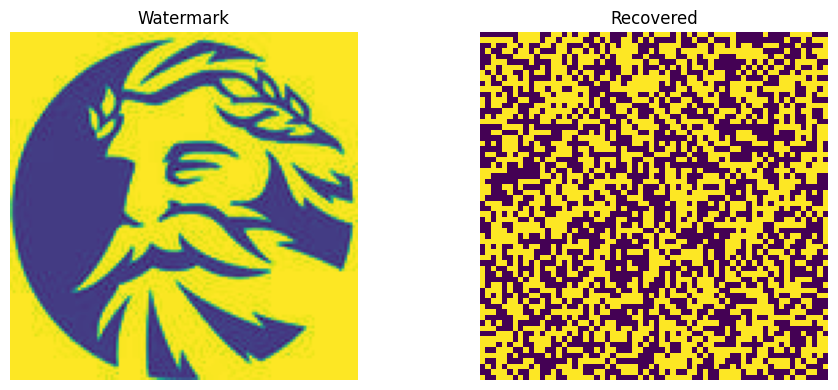

In [10]:
import cv2

path_in = "images/wa-cat.jpg"
path_out = "images/wa-cat-cropped.jpg"

image = cv2.imread(path_in)
h, w = image.shape[:2]
image = cv2.resize(image, (w - (w % 2), h - (h % 2)), cv2.INTER_LINEAR)
cv2.imwrite(path_out, image)

# 6) Blind extraction (from the just-saved watermarked image)
recovered_bits = extract_watermark_rgb_dwt_ss(load_rgb(path_out), side)
recovered_logo = bits_to_image(recovered_bits, side["wm_shape"])
# recovered_logo.save(out_recovered)
acc = (recovered_bits == wm_bits).mean()*100
print(f"[Extract] Bit accuracy vs original watermark: {acc:.2f}%")
print(f"[Extract] Recovered watermark saved to: {out_recovered}")

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(wm_img); 
ax[0].set_title(f"Watermark"); ax[0].axis('off')
ax[1].imshow(recovered_logo);   
ax[1].set_title(f"Recovered"); ax[1].axis('off')
plt.tight_layout(); 
plt.show()

In [ ]:
# =============================
# DWT + SVD + QIM-on-S (Blind)
# =============================
import numpy as np
from PIL import Image
import pywt

# --- Helper functions ---
def load_rgb(path):
    return Image.open(path).convert('RGB')

def save_rgb(img, path):
    img.save(path)

def image_to_bits(img_gray, size=(32,32), threshold=128):
    img_gray = img_gray.resize(size).convert('L')
    arr = np.array(img_gray)
    bits = (arr >= threshold).astype(np.uint8).flatten()
    return bits, size

def bits_to_image(bits, size):
    H, W = size
    arr = (bits.reshape(H, W) * 255).astype(np.uint8)
    return Image.fromarray(arr, mode='L')

# --- Core watermarking ---
def embed_dwt_svd_qim(host_rgb, wm_bits, delta=5.0, subband='HL'):
    # Convert to YCbCr
    host_ycbcr = host_rgb.convert('YCbCr')
    Y, Cb, Cr = host_ycbcr.split()
    Y = np.array(Y, dtype=np.float64)

    # 1-level DWT
    LL, (LH, HL, HH) = pywt.dwt2(Y, 'haar')

    # Pick subband
    band = HL if subband == 'HL' else LH

    # Apply SVD
    U, S, Vt = np.linalg.svd(band, full_matrices=False)
    S_mod = S.copy()

    # Embed bits with QIM on singular values
    n_bits = min(len(wm_bits), len(S_mod))
    for i in range(n_bits):
        q = np.floor(S_mod[i] / delta)
        S_mod[i] = q*delta + (delta/2 if wm_bits[i] else 0)

    # Reconstruct band
    band_mod = U @ np.diag(S_mod) @ Vt
    if subband == 'HL':
        HL = band_mod
    else:
        LH = band_mod

    # Inverse DWT
    Yw = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    Yw = np.clip(Yw, 0, 255).astype(np.uint8)

    # Merge and convert to RGB
    out_img = Image.merge('YCbCr', (Image.fromarray(Yw), Cb, Cr)).convert('RGB')
    return out_img

def extract_dwt_svd_qim(wm_rgb, wm_len, delta=5.0, subband='HL'):
    wm_ycbcr = wm_rgb.convert('YCbCr')
    Y, _, _ = wm_ycbcr.split()
    Y = np.array(Y, dtype=np.float64)

    LL, (LH, HL, HH) = pywt.dwt2(Y, 'haar')
    band = HL if subband == 'HL' else LH

    # SVD
    U, S, Vt = np.linalg.svd(band, full_matrices=False)

    # QIM decoding from singular values
    wm_bits = []
    for i in range(wm_len):
        r = np.mod(S[i], delta)
        wm_bits.append(1 if r > (delta/2) else 0)

    return np.array(wm_bits, dtype=np.uint8)

# =============================
# Example Usage
# =============================
# 1) Load host & watermark
host = load_rgb("host_color.jpg")
wm_bits, wm_shape = image_to_bits(load_rgb("watermark.png"), size=(32,32))

# 2) Embed
watermarked_img = embed_dwt_svd_qim(host, wm_bits, delta=5.0, subband='HL')
save_rgb(watermarked_img, "watermarked_svd_qim.png")

# 3) Extract (Blind)
recovered_bits = extract_dwt_svd_qim(load_rgb("watermarked_svd_qim.png"),
                                     wm_len=wm_shape[0]*wm_shape[1],
                                     delta=5.0,
                                     subband='HL')
recovered_logo = bits_to_image(recovered_bits, wm_shape)
recovered_logo.save("recovered_svd_qim.png")


grok

In [ ]:
import numpy as np
import pywt
from scipy.ndimage import zoom  # For resizing watermark

# Example host: Arbitrary size, e.g., 4x4 (can be any shape)
host = np.array([
    [100, 110, 120, 130],
    [140, 150, 160, 170],
    [180, 190, 200, 210],
    [220, 230, 240, 250]
], dtype=float)

# Watermark: Any size, will be resized
watermark = np.array([
    [0, 50],
    [100, 150]
], dtype=float)

# Scaling factor
alpha = 0.05

# Embedding
coeffs_host = pywt.dwt2(host, 'haar')
cA_host, (cH_host, cV_host, cD_host) = coeffs_host

# Resize watermark to match cA_host shape
resize_factor = (cA_host.shape[0] / watermark.shape[0], cA_host.shape[1] / watermark.shape[1])
watermark_resized = zoom(watermark, resize_factor, order=1)  # Bilinear interp

# SVD on host LL and resized watermark
U_h, S_h, Vt_h = np.linalg.svd(cA_host, full_matrices=False)
U_w, S_w, Vt_w = np.linalg.svd(watermark_resized, full_matrices=False)

# Pad S_w if shorter than S_h (for safety)
if len(S_w) < len(S_h):
    S_w = np.pad(S_w, (0, len(S_h) - len(S_w)))

# Embed: Additive on singular values
S_embedded = S_h + alpha * S_w

# Reconstruct watermarked LL and image
cA_watermarked = U_h @ np.diag(S_embedded) @ Vt_h
coeffs_watermarked = (cA_watermarked, (cH_host, cV_host, cD_host))
watermarked_host = pywt.idwt2(coeffs_watermarked, 'haar')

print("Watermarked Host (rounded):\n", np.round(watermarked_host))

# Non-Blind Extraction (for comparison, needs original S_h)
S_wm_nonblind = np.linalg.svd(cA_watermarked, full_matrices=False)[1]  # Just S_wm
S_extracted_nonblind = (S_wm_nonblind - S_h) / alpha
extracted_nonblind = U_w @ np.diag(S_extracted_nonblind) @ Vt_w
print("Non-Blind Extracted Watermark (rounded):\n", np.round(extracted_nonblind))

# Approximate Blind Extraction (no original needed)
# Estimate S_h ≈ S_wm (since alpha small), or smooth for better approx
coeffs_wm = pywt.dwt2(watermarked_host, 'haar')
cA_wm, _ = coeffs_wm
U_wm, S_wm, Vt_wm = np.linalg.svd(cA_wm, full_matrices=False)

# Simple approximation: S_h_est = S_wm - alpha * np.mean(S_wm) (adjust for your case)
S_h_est = S_wm - alpha * np.mean(S_wm)  # Basic estimate; use curve fit for better
S_extracted_blind = (S_wm - S_h_est) / alpha

# Reconstruct using watermark's original U_w and Vt_w (assumed known, or use wm's)
extracted_blind = U_w @ np.diag(S_extracted_blind) @ Vt_w
print("Approximate Blind Extracted Watermark (rounded):\n", np.round(extracted_blind))

# Note: For more accurate blind, implement log-scaling: S_embedded = np.exp(np.log(S_h) + alpha * S_w)
# Then blind extract: S_extracted = (np.log(S_wm) - np.log(S_h_est)) / alpha

In [1]:
import cv2
import numpy as np
import pywt
from scipy.ndimage import zoom

def embed_watermark(host_path, watermark_path, alpha=0.05, output_path='watermarked.jpg'):
    """
    Embed a watermark image into a color host image using DWT + SVD.
    Handles any size, including odd dimensions.
    """
    # Load images
    host = cv2.imread(host_path)  # Color: (H, W, 3)
    if host is None:
        raise ValueError("Could not load host image.")
    watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)  # Grayscale watermark
    if watermark is None:
        raise ValueError("Could not load watermark image.")
    
    # Get original sizes
    original_host_size = host.shape[:2]  # (H, W)
    original_watermark_size = watermark.shape  # (h, w)
    
    # Split host into RGB channels
    channels = cv2.split(host)
    watermarked_channels = []
    
    for channel in channels:
        channel = channel.astype(float)
        
        # Apply DWT (Haar, level 1)
        coeffs = pywt.dwt2(channel, 'haar')
        cA, (cH, cV, cD) = coeffs  # cA is LL
        
        # Resize watermark to match cA shape
        resize_factor = (cA.shape[0] / watermark.shape[0], cA.shape[1] / watermark.shape[1])
        watermark_resized = zoom(watermark.astype(float), resize_factor, order=1)
        
        # SVD on LL and resized watermark
        U_h, S_h, Vt_h = np.linalg.svd(cA, full_matrices=False)
        U_w, S_w, Vt_w = np.linalg.svd(watermark_resized, full_matrices=False)
        
        # Pad S_w if shorter
        if len(S_w) < len(S_h):
            S_w = np.pad(S_w, (0, len(S_h) - len(S_w)))
        
        # Embed: Additive on singular values
        S_embedded = S_h + alpha * S_w
        
        # Reconstruct watermarked LL
        cA_watermarked = U_h @ np.diag(S_embedded) @ Vt_h
        
        # Reconstruct channel with IDWT
        coeffs_watermarked = (cA_watermarked, (cH, cV, cD))
        watermarked_channel = pywt.idwt2(coeffs_watermarked, 'haar')
        watermarked_channels.append(watermarked_channel)
    
    # Merge channels and clip to 0-255
    watermarked_host = cv2.merge(watermarked_channels)
    watermarked_host = np.clip(watermarked_host, 0, 255).astype(np.uint8)
    
    # Save
    cv2.imwrite(output_path, watermarked_host)
    print(f"Watermarked image saved to {output_path}")
    return original_host_size, original_watermark_size

def extract_watermark_blind(watermarked_path, original_host_size, original_watermark_size, alpha=0.05, output_path='extracted_blind.jpg'):
    """
    Approximate blind extraction: No original host needed.
    Handles resized watermarked by resizing back to original host size.
    Estimation: Simple mean-based approx; for better, use log-scaling in embed.
    """
    # Load watermarked
    watermarked = cv2.imread(watermarked_path)
    if watermarked is None:
        raise ValueError("Could not load watermarked image.")
    
    # Resize to original host size if different
    if watermarked.shape[:2] != original_host_size:
        watermarked = cv2.resize(watermarked, (original_host_size[1], original_host_size[0]))
    
    # Split channels
    wm_channels = cv2.split(watermarked.astype(float))
    extracted_channels = []
    
    for wm_channel in wm_channels:
        # DWT on watermarked
        coeffs_wm = pywt.dwt2(wm_channel, 'haar')
        cA_wm, _ = coeffs_wm
        
        # SVD
        U_wm, S_wm, Vt_wm = np.linalg.svd(cA_wm, full_matrices=False)
        
        # Approximate S_h est (simple: subtract scaled mean)
        S_h_est = S_wm - alpha * np.mean(S_wm)
        
        # Extract
        S_extracted = (S_wm - S_h_est) / alpha
        
        # Reconstruct
        extracted = U_wm @ np.diag(S_extracted) @ Vt_wm
        extracted_channels.append(extracted)
    
    # Average for grayscale
    extracted_watermark = np.mean(extracted_channels, axis=0)
    extracted_watermark = np.clip(extracted_watermark, 0, 255).astype(np.uint8)
    
    # Resize to original watermark size
    # extracted_watermark = cv2.resize(extracted_watermark, (original_watermark_size[1], original_watermark_size[0]))
    
    cv2.imwrite(output_path, extracted_watermark)
    print(f"Blind extracted watermark saved to {output_path}")

# Example usage:
# original_host_size, original_watermark_size = embed_watermark('host.jpg', 'watermark.jpg', alpha=0.05, output_path='watermarked.jpg')
# extract_watermark_nonblind('watermarked_resized.jpg', 'host.jpg', original_watermark_size)  # If watermarked was resized
# extract_watermark_blind('watermarked_resized.jpg', original_host_size, original_watermark_size)

In [2]:
original_host_size, original_watermark_size = embed_watermark('images/cat.webp', 'images/logo.png', alpha=0.1, output_path='images/new-watermarked.jpg')

Watermarked image saved to images/new-watermarked.jpg


In [3]:
extract_watermark_blind('images/new-watermarked.jpg', original_host_size, original_watermark_size, alpha=0.1, output_path='images/extracted_blind.jpg')

Blind extracted watermark saved to images/extracted_blind.jpg


Gemini

In [24]:
import cv2
import numpy as np
import pywt

def embed_watermark_blind(host_path, watermark_path, q_step=50, output_path='watermarked_blind.png'):
    """
    Embeds a watermark into a host image using a truly blind DWT-SVD-QIM method.
    The watermark is converted to a binary stream and embedded by quantizing the
    singular values of the host's LL band.
    """
    # Load images
    host = cv2.imread(host_path)
    if host is None:
        raise ValueError("Could not load host image.")
    watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
    if watermark is None:
        raise ValueError("Could not load watermark image.")

    # --- 1. Preparation ---
    # Get the blue channel of the host image for embedding (often most robust)
    host_channel = host[:, :, 0].astype(float)
    
    # Binarize the watermark: pixels > 128 are 1, others are 0
    _, watermark_bin = cv2.threshold(watermark, 128, 1, cv2.THRESH_BINARY)
    watermark_flat = watermark_bin.flatten()
    watermark_len = len(watermark_flat)

    # --- 2. DWT and SVD on Host ---
    # Apply DWT to the host channel
    coeffs_host = pywt.dwt2(host_channel, 'haar')
    cA_host, (cH, cV, cD) = coeffs_host

    # Apply SVD to the LL band (cA_host)
    U_host, S_host, Vt_host = np.linalg.svd(cA_host)
    
    if watermark_len > len(S_host):
        raise ValueError("Watermark is too large for the host image's capacity.")

    # --- 3. Embed Watermark using QIM ---
    S_quantized = np.copy(S_host)
    for i in range(watermark_len):
        s_i = S_host[i]
        bit = watermark_flat[i]
        
        # Find the quantization level
        quant_level = np.floor(s_i / q_step)
        
        # Embed bit '1' or '0'
        if bit == 1:
            # Embed '1': move to the 3/4 mark of the interval
            s_quantized = quant_level * q_step + 0.75 * q_step
        else: # bit == 0
            # Embed '0': move to the 1/4 mark of the interval
            s_quantized = quant_level * q_step + 0.25 * q_step
        
        S_quantized[i] = s_quantized

    # --- 4. Reconstruct Image ---
    # Reconstruct the LL band with the modified singular values
    cA_watermarked = U_host @ np.diag(S_quantized) @ Vt_host
    
    # Apply IDWT to reconstruct the channel
    coeffs_modified = (cA_watermarked, (cH, cV, cD))
    channel_watermarked = pywt.idwt2(coeffs_modified, 'haar')
    
    # Combine the modified channel with the original G and R channels
    host_watermarked = host.copy().astype(float)
    host_watermarked[:, :, 0] = channel_watermarked
    
    # Clip values to the valid 0-255 range
    host_watermarked = np.clip(host_watermarked, 0, 255).astype(np.uint8)

    # Save the watermarked image (use a lossless format like PNG)
    cv2.imwrite(output_path, host_watermarked)
    print(f"Blind watermarked image saved to {output_path}")
    
    # Return original watermark dimensions for extraction
    return watermark.shape


def extract_watermark_blind(watermarked_path, original_watermark_shape, q_step=50, output_path='extracted_blind.png'):
    """
    Extracts a watermark from an image using the blind DWT-SVD-QIM method.
    It does NOT require the original host image.
    """
    # Load watermarked image
    watermarked_image = cv2.imread(watermarked_path)
    if watermarked_image is None:
        raise ValueError("Could not load watermarked image.")

    # --- 1. DWT and SVD on Watermarked Image ---
    # Use the same channel as embedding (blue)
    watermarked_channel = watermarked_image[:, :, 0].astype(float)
    
    # Apply DWT
    coeffs_wm = pywt.dwt2(watermarked_channel, 'haar')
    cA_wm, _ = coeffs_wm
    
    # Apply SVD
    _, S_wm, _ = np.linalg.svd(cA_wm)

    # --- 2. Extract Watermark Bits using QIM ---
    watermark_len = original_watermark_shape[0] * original_watermark_shape[1]
    extracted_bits = []

    for i in range(watermark_len):
        s_wm_i = S_wm[i]
        
        # Check the remainder to determine the bit
        remainder = s_wm_i % q_step
        
        if remainder > q_step / 2:
            extracted_bits.append(1)
        else:
            extracted_bits.append(0)
            
    # --- 3. Reconstruct Watermark Image ---
    extracted_watermark_flat = np.array(extracted_bits)
    # Reshape the flat array back into the original watermark's 2D shape
    extracted_watermark = extracted_watermark_flat.reshape(original_watermark_shape)
    
    # Scale to 0-255 for visualization
    extracted_watermark = (extracted_watermark * 255).astype(np.uint8)
    
    cv2.imwrite(output_path, extracted_watermark)
    print(f"Blind extracted watermark saved to {output_path}")

In [28]:
# Embed the watermark
original_wm_shape = embed_watermark_blind('images/cat.webp', 'images/sm_watermark.jpg', q_step=50, output_path='images/watermarked_blind.png')

ValueError: Watermark is too large for the host image's capacity.

In [ ]:
# Extract the watermark without using the original host image
extract_watermark_blind('images/watermarked_blind.png', original_wm_shape, q_step=50, output_path='images/extracted_blind.png')

In [64]:
import cv2
import numpy as np
import pywt
import math

def embed_watermark_blind_block(host_path, watermark_path, q_step=50, block_size=4, output_path='images/watermarked_blind.png'):
    """
    Embeds a watermark by breaking the LL band into blocks and using QIM on each block's SVD.
    This provides much higher capacity than applying SVD to the whole LL band.
    """
    # Load images
    host = cv2.imread(host_path)
    if host is None:
        raise ValueError("Could not load host image.")
    watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
    if watermark is None:
        raise ValueError("Could not load watermark image.")
    
    watermark = cv2.resize(watermark, (64,64))

    # --- 1. Preparation ---
    host_channel = host[:, :, 0].astype(float)
    _, watermark_bin = cv2.threshold(watermark, 128, 1, cv2.THRESH_BINARY)
    watermark_flat = watermark_bin.flatten()
    watermark_len = len(watermark_flat)

    # --- 2. DWT on Host ---
    coeffs_host = pywt.dwt2(host_channel, 'haar')
    cA_host, (cH, cV, cD) = coeffs_host

    # --- 3. Block-Based Embedding ---
    cA_watermarked = cA_host.copy()
    num_blocks_h = int(cA_host.shape[0] / block_size)
    num_blocks_w = int(cA_host.shape[1] / block_size)
    
    # Check if capacity is sufficient
    capacity = num_blocks_h * num_blocks_w
    if watermark_len > capacity:
        raise ValueError(f"Watermark is too large. Max capacity is {capacity} bits, watermark needs {watermark_len} bits.")

    watermark_idx = 0
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            if watermark_idx >= watermark_len:
                break # All watermark bits embedded

            # Get the block
            h_start, h_end = i * block_size, (i + 1) * block_size
            w_start, w_end = j * block_size, (j + 1) * block_size
            block = cA_host[h_start:h_end, w_start:w_end]

            # Apply SVD to the block
            U_block, S_block, Vt_block = np.linalg.svd(block)
            
            # Get the watermark bit to embed
            bit = watermark_flat[watermark_idx]
            
            # Quantize the first (and strongest) singular value of the block
            s0 = S_block[0]
            quant_level = np.floor(s0 / q_step)
            
            if bit == 1:
                s0_quantized = quant_level * q_step + 0.75 * q_step
            else: # bit == 0
                s0_quantized = quant_level * q_step + 0.25 * q_step
            
            # Replace the original singular value
            S_block[0] = s0_quantized
            
            # Reconstruct the block
            modified_block = U_block @ np.diag(S_block) @ Vt_block
            
            # Place the modified block back into the watermarked LL band
            cA_watermarked[h_start:h_end, w_start:w_end] = modified_block
            
            watermark_idx += 1
        if watermark_idx >= watermark_len:
            break
            
    # --- 4. Reconstruct Image ---
    coeffs_modified = (cA_watermarked, (cH, cV, cD))
    channel_watermarked = pywt.idwt2(coeffs_modified, 'haar')
    
    host_watermarked = host.copy().astype(float)
    host_watermarked[:, :, 0] = channel_watermarked
    host_watermarked = np.clip(host_watermarked, 0, 255).astype(np.uint8)

    cv2.imwrite(output_path, host_watermarked)
    print(f"Blind watermarked image saved to {output_path}")
    
    return watermark.shape, block_size

def extract_watermark_blind_block(watermarked_path, original_watermark_shape, q_step=50, block_size=4, output_path='images/extracted_blind.png'):
    """
    Extracts a watermark from an image using the blind block-based DWT-SVD-QIM method.
    """
    watermarked_image = cv2.imread(watermarked_path)
    if watermarked_image is None:
        raise ValueError("Could not load watermarked image.")

    # --- 1. DWT on Watermarked Image ---
    watermarked_channel = watermarked_image[:, :, 0].astype(float)
    coeffs_wm = pywt.dwt2(watermarked_channel, 'haar')
    cA_wm, _ = coeffs_wm
    
    # --- 2. Block-Based Extraction ---
    watermark_len = original_watermark_shape[0] * original_watermark_shape[1]
    extracted_bits = []
    
    num_blocks_h = int(cA_wm.shape[0] / block_size)
    num_blocks_w = int(cA_wm.shape[1] / block_size)

    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            if len(extracted_bits) >= watermark_len:
                break

            # Get the block
            h_start, h_end = i * block_size, (i + 1) * block_size
            w_start, w_end = j * block_size, (j + 1) * block_size
            block = cA_wm[h_start:h_end, w_start:w_end]
            
            # SVD on the block
            _, S_block, _ = np.linalg.svd(block)
            
            # Extract the bit by checking the quantization of the first singular value
            s0 = S_block[0]
            remainder = s0 % q_step
            
            if remainder > q_step / 2:
                extracted_bits.append(1)
            else:
                extracted_bits.append(0)
        if len(extracted_bits) >= watermark_len:
            break

    # --- 3. Reconstruct Watermark Image ---
    extracted_watermark_flat = np.array(extracted_bits)
    extracted_watermark = extracted_watermark_flat.reshape(original_watermark_shape)
    extracted_watermark = (extracted_watermark * 255).astype(np.uint8)

    # --- ADD THIS LINE FOR CLEANING ---
    # This forces any pixel > 128 to become 255 (white) and the rest to become 0 (black).
    _, extracted_watermark = cv2.threshold(extracted_watermark, 128, 255, cv2.THRESH_BINARY)
    # --- END OF ADDED LINE ---
    
    cv2.imwrite(output_path, extracted_watermark)
    print(f"Blind extracted watermark saved to {output_path}")

def calculate_psnr(original_img_path, watermarked_img_path):
    """Calculates the PSNR between two images."""

    original_img = cv2.imread(original_img_path)
    watermarked_img = cv2.imread(watermarked_img_path)

    # Ensure images are the same size and type
    original_img = original_img.astype(np.float64)
    watermarked_img = watermarked_img.astype(np.float64)
    
    mse = np.mean((original_img - watermarked_img) ** 2)
    if mse == 0:
        return float('inf') # PSNR is infinite if images are identical
    
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def calculate_ber(original_wm_path, extracted_wm_path):
    original_wm = cv2.imread(original_wm_path, cv2.IMREAD_GRAYSCALE)
    original_wm = cv2.resize(original_wm, (64, 64))  # Ensure same size as watermark

    _, original_wm_bin = cv2.threshold(original_wm, 128, 1, cv2.THRESH_BINARY)
    original_wm_flat = original_wm_bin.flatten()

    extracted_wm = cv2.imread(extracted_wm_path, cv2.IMREAD_GRAYSCALE)
    _, extracted_wm_bin = cv2.threshold(extracted_wm, 128, 1, cv2.THRESH_BINARY)
    extracted_wm_flat = extracted_wm_bin.flatten()

    """Calculates the Bit Error Rate between two binary streams."""
    if len(original_wm_flat) != len(extracted_wm_flat):
        raise ValueError("Watermark streams must have the same length.")
    
    error_bits = np.sum(original_wm_flat != extracted_wm_flat)
    ber = error_bits / len(original_wm_flat)
    return ber

In [65]:
Q_STEP = 50
HOST = 'images/lg-cat.webp' 
WATERMARK = 'images/s.jpg'
WATERMARKED = 'images/watermarked_blind.png'
WATERMARK_EXTRACTED = 'images/extracted_blind.png'

# Embed the watermark
original_wm_shape, block_size = embed_watermark_blind_block(HOST, WATERMARK, q_step=Q_STEP, block_size=4)

print("PSNR: ", calculate_psnr(HOST, WATERMARKED))

cv2.imshow("Watermarked Image", cv2.imread(WATERMARKED))
cv2.waitKey(0)

Blind watermarked image saved to images/watermarked_blind.png
PSNR:  59.25986835736299


-1

In [67]:
WATERMARKED = 'images/wa-new-cat.jpg'

# Extract the watermark without using the original host image
extract_watermark_blind_block(WATERMARKED, original_wm_shape, q_step=Q_STEP, block_size=block_size)

print("BER: ", calculate_ber(WATERMARK, WATERMARK_EXTRACTED))

cv2.imshow("Extracted Watermark", cv2.imread(WATERMARK_EXTRACTED))
cv2.waitKey(0)

Blind extracted watermark saved to images/extracted_blind.png
BER:  0.52734375


-1

In [4]:
import cv2
import numpy as np
import pywt
import math

class RobustWatermarker:
    def __init__(self, q_step=100, patch_size=64):
        """
        Initializes the robust watermarker.
        :param q_step: Quantization step for embedding (strength).
        :param patch_size: The size of the normalized square patch for embedding.
        """
        self.q_step = q_step
        self.patch_size = patch_size
        self.sift = cv2.SIFT_create()

    def _get_normalized_patch(self, image, keypoint):
        """
        Extracts and normalizes a patch around a keypoint to a standard size and orientation.
        This is the core of the geometric robustness.
        """
        # Get the transformation matrix to cancel out rotation and scale
        angle = -keypoint.angle
        scale = self.patch_size / (keypoint.size * 2) # Factor of 2 for better fit
        center = (keypoint.pt[0], keypoint.pt[1])
        
        M = cv2.getRotationMatrix2D(center, angle, scale)
        
        # Adjust translation to center the patch
        M[0, 2] -= center[0] - self.patch_size / 2
        M[1, 2] -= center[1] - self.patch_size / 2
        
        # Apply the transformation (warp)
        normalized_patch = cv2.warpAffine(image, M, (self.patch_size, self.patch_size))
        return normalized_patch

    def embed(self, host_path, watermark_path, output_path='watermarked_robust.png'):
        """Embeds a watermark robustly using SIFT features."""
        host_original = cv2.imread(host_path)
        if host_original is None: raise ValueError("Could not load host image.")
        
        host_to_watermark = host_original.copy()
        gray_host = cv2.cvtColor(host_original, cv2.COLOR_BGR2GRAY)

        watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
        if watermark is None: raise ValueError("Could not load watermark.")

        watermark = cv2.resize(watermark, (64,64), interpolation=cv2.INTER_AREA)

        _, watermark_bin = cv2.threshold(watermark, 128, 1, cv2.THRESH_BINARY)
        watermark_flat = watermark_bin.flatten()

        # 1. Find stable keypoints in the host image
        keypoints, _ = self.sift.detectAndCompute(gray_host, None)
        
        # Sort keypoints by response (strength) to use the most stable ones
        keypoints = sorted(keypoints, key=lambda x: -x.response)
        
        capacity = len(keypoints)
        if len(watermark_flat) > capacity:
            raise ValueError(f"Watermark is too large. Max capacity is {capacity} bits, watermark needs {len(watermark_flat)} bits.")

        print(f"Embedding {len(watermark_flat)} bits into {len(keypoints)} available keypoints...")

        # 2. Embed one bit in each keypoint's normalized region
        for i, bit in enumerate(watermark_flat):
            kp = keypoints[i]
            
            # Get the normalized patch from the Y channel (luminance)
            host_yuv = cv2.cvtColor(host_to_watermark, cv2.COLOR_BGR2YUV)
            y_channel = host_yuv[:, :, 0]
            
            normalized_patch = self._get_normalized_patch(y_channel, kp)
            
            # Embed using DWT-SVD-QIM on the patch
            coeffs = pywt.dwt2(normalized_patch.astype(float), 'haar')
            cA, (cH, cV, cD) = coeffs
            U, S, Vt = np.linalg.svd(cH)
            
            s0 = S[0]
            quant_level = np.floor(s0 / self.q_step)
            s0_quantized = (quant_level * self.q_step + 0.75 * self.q_step) if bit == 1 else (quant_level * self.q_step + 0.25 * self.q_step)
            S[0] = s0_quantized
            
            modified_cH = U @ np.diag(S) @ Vt
            modified_patch = pywt.idwt2((cA, (modified_cH, cV, cD)), 'haar')
            
            # 3. Inversely transform the patch back into the host image
            angle = kp.angle
            scale = (kp.size * 2) / self.patch_size
            center = (kp.pt[0], kp.pt[1])
            
            inv_M = cv2.getRotationMatrix2D((self.patch_size/2, self.patch_size/2), angle, scale)
            inv_M[0, 2] += center[0] - self.patch_size/2
            inv_M[1, 2] += center[1] - self.patch_size/2

            # Warp the patch back, creating a mask to blend it smoothly
            temp_img = np.zeros_like(y_channel, dtype=float)
            temp_img = cv2.warpAffine(modified_patch, inv_M, (y_channel.shape[1], y_channel.shape[0]), temp_img, flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_TRANSPARENT)
            
            # Blend the patch into the original Y channel
            mask = (temp_img != 0)
            y_channel[mask] = temp_img[mask]
            host_yuv[:, :, 0] = y_channel
            host_to_watermark = cv2.cvtColor(host_yuv, cv2.COLOR_YUV2BGR)

        host_watermarked = np.clip(host_to_watermark, 0, 255).astype(np.uint8)
        cv2.imwrite(output_path, host_watermarked)

        psnr = self._calculate_psnr(host_original, host_watermarked)
        print(f"Embedding complete. PSNR: {psnr:.2f} dB")
        return watermark.shape

    def extract(self, watermarked_path, original_watermark_shape):
        """Extracts a watermark from a (potentially attacked) image."""
        watermarked_image = cv2.imread(watermarked_path)
        if watermarked_image is None: raise ValueError("Could not load watermarked image.")
        
        gray_watermarked = cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2GRAY)
        
        # 1. Find keypoints in the (attacked) watermarked image
        keypoints, _ = self.sift.detectAndCompute(gray_watermarked, None)
        keypoints = sorted(keypoints, key=lambda x: -x.response)
        
        watermark_len = original_watermark_shape[0] * original_watermark_shape[1]
        
        if len(keypoints) < watermark_len:
            print(f"Warning: Found only {len(keypoints)} keypoints, may not be able to recover full watermark of length {watermark_len}.")
            watermark_len = len(keypoints)

        extracted_bits = []
        
        yuv_watermarked = cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2YUV)
        y_channel = yuv_watermarked[:, :, 0]

        # 2. Extract bit from each normalized patch
        for i in range(watermark_len):
            kp = keypoints[i]
            normalized_patch = self._get_normalized_patch(y_channel, kp)
            
            coeffs = pywt.dwt2(normalized_patch, 'haar')
            cA, (cH, cV, cD) = coeffs
            _, S, _ = np.linalg.svd(cH)

            s0 = S[0]
            remainder = s0 % self.q_step
            extracted_bits.append(1) if remainder > self.q_step / 2 else extracted_bits.append(0)

        return np.array(extracted_bits)

    def _calculate_psnr(self, original, compressed):
        mse = np.mean((original.astype("float") - compressed.astype("float")) ** 2)
        if mse == 0: return float('inf')
        return 20 * math.log10(255.0 / math.sqrt(mse))

    def _calculate_ber(self, original_bits, extracted_bits):
        len_orig = len(original_bits)
        len_ext = len(extracted_bits)
        errors = np.sum(original_bits[:min(len_orig, len_ext)] != extracted_bits[:min(len_orig, len_ext)])
        return errors / len_orig

In [5]:
HOST = 'images/lg-cat.webp' 
WATERMARK = 'images/s.jpg'
WATERMARKED = 'images/watermarked_blind.png'
WATERMARK_EXTRACTED = 'images/extracted_blind.png'

# --- Setup ---
watermarker = RobustWatermarker(q_step=25, patch_size=32)
host_img_path = HOST
wm_img_path = WATERMARK
watermarked_output_path = WATERMARKED

# --- Embedding ---
print("--- EMBEDDING ---")
original_wm_shape = watermarker.embed(host_img_path, wm_img_path, watermarked_output_path)

# --- Create an Attacked Version (Example: resize + JPEG compression) ---
attacked_path = 'attacked_image.jpg'
img = cv2.imread(watermarked_output_path)
# Resize attack
attacked_img = cv2.resize(img, (0, 0), fx=0.8, fy=0.8) 
# JPEG compression attack (quality=90)
cv2.imwrite(attacked_path, attacked_img, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
print(f"\nCreated an attacked image (resized + JPEG) at '{attacked_path}'")

--- EMBEDDING ---
Embedding 4096 bits into 20813 available keypoints...
Embedding complete. PSNR: 31.58 dB

Created an attacked image (resized + JPEG) at 'attacked_image.jpg'


In [6]:
# --- Extraction ---
print("\n--- EXTRACTION ---")
# Load original watermark to calculate BER
original_wm = cv2.imread(wm_img_path, cv2.IMREAD_GRAYSCALE)
_, original_wm_bin = cv2.threshold(original_wm, 128, 1, cv2.THRESH_BINARY)
original_wm_flat = original_wm_bin.flatten()

# Extract from the attacked image
extracted_bits = watermarker.extract(WATERMARKED, original_wm_shape)

# --- NEW: Convert bits to image and display ---
if extracted_bits.size > 0:
    # Reshape the flat array of bits into the original 2D shape
    h, w = original_wm_shape
    num_pixels = h * w
    
    # Ensure we only use the number of bits that can form the image
    if len(extracted_bits) >= num_pixels:
        # Reshape and scale bits (0,1) to image pixels (0,255)
        recovered_wm_array = (extracted_bits[:num_pixels].reshape(h, w) * 255).astype(np.uint8)
        
        # Display the recovered watermark
        cv2.imshow("Recovered Watermark", recovered_wm_array)
        cv2.waitKey(0)
        # cv2.destroyAllWindows() # Optional: call this when you are done with all windows
        
        # Optionally save the image
        cv2.imwrite(WATERMARK_EXTRACTED, recovered_wm_array)
        print(f"Recovered watermark image saved to '{WATERMARK_EXTRACTED}'")
    else:
        print("Warning: Not enough bits were extracted to reconstruct the full watermark image.")
else:
    print("Extraction failed: No bits were recovered.")

# --- Results ---
ber = watermarker._calculate_ber(original_wm_flat, extracted_bits)
print(f"\n--- RESULTS ---")
print(f"Bit Error Rate (BER) after attack: {ber:.4f}")
if ber == 0.0:
    print("✅ Watermark extracted perfectly.")
else:
    print(f"⚠️ Watermark extracted with {int(ber*len(original_wm_flat))} errors.")


--- EXTRACTION ---
Recovered watermark image saved to 'images/extracted_blind.png'

--- RESULTS ---
Bit Error Rate (BER) after attack: 0.0022
⚠️ Watermark extracted with 2111 errors.
